In [75]:
import numpy as np
import numba
import matplotlib.pyplot as plt

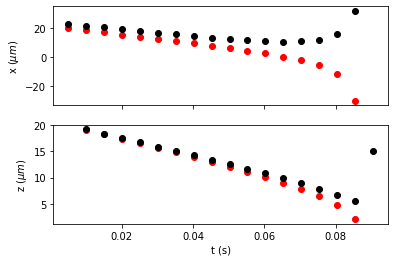

In [109]:
#initial height
H = 20

#particle radii:
ap_i = 3 #microns
ap_j = 3 #microns

#densities (keep density in kg/m^3)
rho_m = 1000
rho_i = 965
rho_j = 965

#gravity (um/s^2)
grav = 9.81e6

#viscosity of medium (Pa s)
eta = 1e-3

#stokes drag
gamma0_i = 6*np.pi*eta*ap_i
gamma0_j = 6*np.pi*eta*ap_j


#initial condition
Xi = np.array([20, H])
Xj = np.array([20+ap_i, H])
z0_i = Xi[1]
z0_j = Xj[1]

@numba.jit()

def r(Xi, Xj): #calculate 2d distance between particles
    return np.sqrt((Xi[1]-Xj[1])**2 + (Xi[0]-Xj[0])**2)
    
def theta(Xi, Xj): #calculate angle between particles
    if Xi[0]-Xj[0] == 0:
        return np.pi/2
    else:
        return np.arctan([(Xi[1]-Xj[1]), Xi[0]-Xj[0]])[1]

def f(Xi, Xj):
    m = (rho_i - rho_m)*4/3*np.pi*(ap_i*1e-6)**3 
    A = m * grav/gamma0_i * np.array([0, 1])
    r_ij = r(Xi, Xj)
    theta_ij = theta(Xi, Xj)
    H_inv = np.array([[np.sin(theta_ij)**2+1, \
                       -np.sin(theta_ij)*np.cos(theta_ij)],\
                      [-np.sin(theta_ij)*np.cos(theta_ij), \
                       1/2*(np.cos(2*theta_ij)+3)]])#inverse mobility matrix
    return A - 2*r_ij/3*ap_i * np.matmul(H_inv, Xj)

def g(Xi, Xj):
    m = (rho_j - rho_m)*4/3*np.pi*(ap_j*1e-6)**3 
    A = m * grav/gamma0_j * np.array([0, 1])
    r_ij = r(Xi, Xj)
    theta_ij = theta(Xi, Xj)
    H_inv = np.array([[np.sin(theta_ij)**2+1, \
                       -np.sin(theta_ij)*np.cos(theta_ij)],\
                      [-np.sin(theta_ij)*np.cos(theta_ij), \
                       1/2*(np.cos(2*theta_ij)+3)]])#inverse mobility matrix
    return A - 2*r_ij/3*ap_j * np.matmul(H_inv, Xi)

fig, axs = plt.subplots(2, sharex = True)
ax0 = axs[0]
ax1 = axs[1]
ax0.set_ylabel(r'x ($\mu m$)')
ax1.set_xlabel(r't (s)')
ax1.set_ylabel(r'z ($\mu m$)')

def iterate(Xi, Xj, t0, tf, n):
    t = np.linspace(t0, tf, n)
    h = t[1] - t[0]
    
    count = 0
    
    for i in range(n):
                        
        #rk4
        k1 = h * f(Xi, Xj)
        l1 = h * g(Xi, Xj)
        
        k2 = h * f(Xi+k1/2, Xj+l1/2)
        l2 = h * g(Xi+k1/2, Xj+l1/2)
        
        k3 = h * f(Xi+k2/2, Xj+l2/2)
        l3 = h * g(Xi+k2/2, Xj+l2/2)
        
        k4 = h * f(Xi+k3, Xj+l3)
        l4 = h * g(Xi+k3, Xj+l3)
        
        k = 1/6 * (k1 + 2*k2 + 2*k3 + k4)
        l = 1/6 * (l1 + 2*l2 + 2*l3 + l4)
        
        count+=h
        #plot x-values
        if Xi[0] > -100 and Xi[0] < 100:
            ax0.plot(count, Xi[0], 'ro')
        if Xj[0] > -100. and Xj[0] < 100:
            ax0.plot(count, Xj[0], 'ko')
        #plot z-values
        if Xi[1] > 0. and Xi[1] < H:
            ax1.plot(count, Xi[1], 'ro')
        if Xj[1] > 0. and Xj[1] < H:
            ax1.plot(count, Xj[1], 'ko')
        
        #update positions
        Xi = np.add(k, Xi) #updated in units of microns
        Xj = np.add(l, Xj)
    
    plt.show()
                
iterate(Xi, Xj, 0,1,200)